# Volatility Forecasts (Part 3 - XGBoost-STES)

This notebook demonstrates the implementation of the Smooth Transition Exponential Smoothing (STES) model. The model is a variant of the Exponential Smoothing (ES) model that captures non-linear dependencies in volatility time series. The STES model is a more advanced version of the ES model that can capture non-linear dependencies in volatility time series. XGBoost-STES is an extension of STES that uses XGBoost to enhance the STES model by better capturing non-linear dependencies in volatility time series.

This notebook corresponds to the blog series [Volatility Forecasts (Part 2 - XGBoost-STES)](https://steveya.github.io/2024/07/12/volatility-forecast-2.html). We have refactored the code used [Volatility Forecasts (Part 1 - STES Models)](https://steveya.github.io/blob/notebooks/volatility_forecast_1.ipynb) in The aim is to replace the logistic function used by the STES model with a xgboost model, and evaluate their relative performance. It is a work in progress and will be updated as I wrap up my implementations.

In [36]:
%load_ext autoreload
%autoreload 2

import sys
import os
project_dir = os.path.abspath('..')
sys.path.insert(0, project_dir)

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from typing import Tuple

from volatility_forecast.data.datamanager import (
    LagReturnDataManager,
    LagAbsReturnDataManager, 
    LagSquareReturnDataManager,
    SquareReturnDataManager,
    HighLownDataManager,
)
from volatility_forecast.model.stes_model import STESModel
from volatility_forecast.model.neural_network_model import (
    RNNVolatilityModel,
    GRUVolatilityModel,
    ImprovedRNNVolatilityModel,
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:

# Data preparation function
def prepare_data(tickers: Tuple[str], start_date: str, end_date: str):
    returns = LagReturnDataManager().get_data(tickers, start_date, end_date)[0] * 1e2
    realized_var = SquareReturnDataManager().get_data(tickers, start_date, end_date)[0] * 1e4
    feature_sets = np.hstack([
        np.ones((len(returns), 1)),
        LagReturnDataManager().get_data(tickers, start_date, end_date)[0] * 1e2,
        LagAbsReturnDataManager().get_data(tickers, start_date, end_date)[0] * 1e2,
        LagSquareReturnDataManager().get_data(tickers, start_date, end_date)[0] * 1e4,
        HighLownDataManager().get_data(tickers, start_date, end_date)[0] * 1e2,
    ])
    realized_var[realized_var==0] = 1e-6
    return feature_sets, realized_var, returns

# Data normalization
def normalize_data(X):
    scaler_X = StandardScaler()
    X_normalized = scaler_X.fit_transform(X[:,1:])
    return np.hstack([np.ones((X.shape[0], 1)), X_normalized])

# Model evaluation function
def evaluate_model(model, X, y, returns, train_size, test_size, epochs=50):
    model.fit(X[:train_size], y[:train_size], returns=returns[:train_size], start_index=0, end_index=train_size, epochs=epochs)
    predictions = model.predict(X, returns=returns)
    rmse = np.sqrt(mean_squared_error(y[train_size:train_size+test_size], predictions[train_size:train_size+test_size]))
    return rmse, predictions


In [3]:
# Main execution
tickers = ("SPY",)
start_date = "2000-01-01"
end_date = "2023-12-31"

X, y, returns = prepare_data(tickers, start_date, end_date)
X_normalized = normalize_data(X)

train_size = 4000
test_size = X.shape[0] - train_size - 1


In [4]:
# ES Model
es_model = STESModel()
es_rmse, es_predictions = evaluate_model(
    es_model, X[:,[0]], y, 
    returns=returns, train_size=train_size, test_size=test_size
)
print(f"ES RMSE: {es_rmse}")

ES RMSE: 4.640452978323074


In [5]:
# STES Model
stes_model = STESModel()
stes_rmse, stes_predictions = evaluate_model(
    stes_model, X[:, :-1], y, 
    returns=returns, train_size=train_size, test_size=test_size
)
print(f"STES RMSE: {stes_rmse}")


STES RMSE: 4.490185456395477


In [6]:
# STES Model
stes_model = STESModel()
stes_rmse, stes_predictions = evaluate_model(
    stes_model, X, y, 
    returns=returns, train_size=train_size, test_size=test_size
)
print(f"STES RMSE: {stes_rmse}")


STES RMSE: 4.464719869246511


In [7]:
rnn_model = RNNVolatilityModel(
    input_size=X.shape[1], 
    hidden_size=2, 
    num_layers=1, 
    #dropout=0.2,
    nonlinearity='relu'
)
rnn_rmse, rnn_predictions = evaluate_model(
    rnn_model, 
    X_normalized, y, 
    returns=returns, 
    train_size=train_size, test_size=test_size, 
    epochs=100
)
print(f"RNN RMSE: {rnn_rmse}")

/opt/homebrew/Caskroom/miniforge/base/envs/ml_env/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([4000, 1])) that is different to the input size (torch.Size([4000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RNN RMSE: 5.385047987176711


In [206]:
rnn_predictions

array([0.87272596, 0.87272596, 0.54540795, ..., 0.87272596, 0.87272596,
       0.87272596], dtype=float32)

In [190]:
rnn_model.print_parameters()

Model Parameters for RNNVolatilityModel:
rnn.weight_ih_l0:
  Shape: torch.Size([2, 5])
  Data (first few values): tensor([-0.7639,  0.0011,  0.0335,  0.0986,  0.4202], device='mps:0')
  Gradient (first few values): tensor([ 0.0067, -0.0019,  0.0190,  0.0221,  0.0281], device='mps:0')

rnn.weight_hh_l0:
  Shape: torch.Size([2, 2])
  Data (first few values): tensor([ 0.4723, -0.7210,  0.6514,  0.5516], device='mps:0')
  Gradient (first few values): tensor([ 0.0118,  0.0027, -0.0057, -0.7482], device='mps:0')

fc.weight:
  Shape: torch.Size([1, 2])
  Data (first few values): tensor([-0.2801,  0.2511], device='mps:0')
  Gradient (first few values): tensor([-0.0401, -1.4684], device='mps:0')

fc.bias:
  Shape: torch.Size([1])
  Data (first few values): tensor([-0.3099], device='mps:0')
  Gradient (first few values): tensor([-0.9251], device='mps:0')



In [37]:
improvd_rnn_model = ImprovedRNNVolatilityModel(
    input_size=X.shape[1], 
    hidden_size=2, 
    num_layers=1, 
    #dropout=0.2,
)
improvd_rnn_rmse, improvd_rnn_predictions = evaluate_model(
    improvd_rnn_model, 
    X_normalized, y, 
    returns=returns, 
    train_size=train_size, test_size=test_size, 
    epochs=100
)
print(f"Improved RNN RMSE: {improvd_rnn_rmse}")

Improved RNN RMSE: 4.512851663329989


<Axes: >

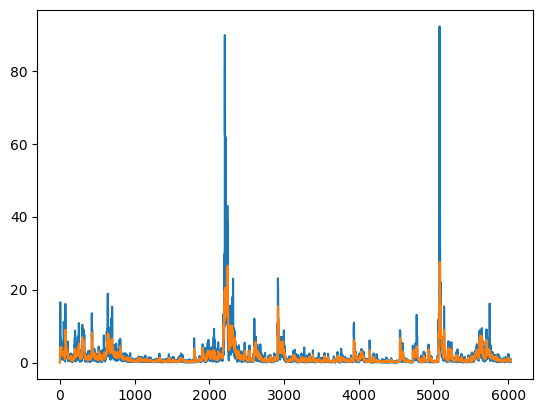

In [42]:
#pd.Series(y.flatten()).plot()
pd.Series(improvd_rnn_predictions.flatten()).plot()
pd.Series(stes_predictions).plot()



In [100]:
# GRU Model
gru_model = GRUVolatilityModel(
    input_size=X.shape[1], 
    hidden_size=32, 
    num_layers=1, 
    dropout=0.2,
)
gru_rmse = evaluate_model(
    gru_model, 
    X_normalized, y_normalized, 
    returns, 
    train_size, test_size, 
    scaler_y=scaler_y
)
print(f"GRU RMSE: {gru_rmse}")



/opt/homebrew/Caskroom/miniforge/base/envs/ml_env/lib/python3.10/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


GRU RMSE: 4.871798045370923


In [ ]:
# RNN Model
for nonlinearity in ["tanh", "relu"]:
    for hidden_size in [2, 8, 16, 32]:
        for num_layers in [1, 3, 5]:
            rnn_model = RNNVolatilityModel(
                input_size=X.shape[1], 
                hidden_size=hidden_size, 
                num_layers=num_layers, 
                dropout=0.2,
                nonlinearity=nonlinearity
            )
            rnn_rmse = evaluate_model(
                rnn_model, 
                X_normalized, y_normalized, 
                returns, 
                train_size, test_size, 
                scaler_y=scaler_y,
                epochs=100
            )
            print(f"Nonlinearity: {nonlinearity}, Hidden Size: {hidden_size}, Num Layers: {num_layers}")
            print(f"RNN RMSE: {rnn_rmse}")


/opt/homebrew/Caskroom/miniforge/base/envs/ml_env/lib/python3.10/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


KeyboardInterrupt: 